# Twitter Starter

In this starter code, we will be learning how to process text into meaningful features that can then be used in predictive modeling. The challenge will be to convert non-structured text into something that can be represented by a column.

# Import packages

In [1]:
import tweepy
from wordcloud import WordCloud
import nltk

Download two of the nltk corpora (see the full list at http://nltk.org/nltk_data/).

In [2]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

Import other packages.

In [4]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeRegressor, plot_tree

In [5]:
# This sets some nicer defaults for plotting.
# This must be run in a separate cell from importing matplotlib due to a bug.
params = {'legend.fontsize': 'large',
          'figure.figsize': (11.0, 11.0),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'xx-large',
          'xtick.labelsize':'large',
          'ytick.labelsize':'large'}
mpl.rcParams.update(params)

# This makes it so that the pandas dataframes don't get truncated horizontally.
pd.options.display.max_columns = 200

# Obtain key codes to access Twitter's API

Sign in with your existing Twitter account (or make a new one) at https://twitter.com/.

Go to https://developer.twitter.com and register to be a developer. Select personal use when asked. Answer four questions indicating use on a student project. 

After completing the developer registration process, select "Create an app" to make a new application.
Fill out the form and feel free to use very generic information (i.e. App name: Your own name, Website URL: "https://www.darden.virginia.edu/", Description: Collect and analyze text). You can ignore the everything after Website URL, except for how the app will be used. Tell us how the app will be used: "This app will collect and analyze text for learning purposes. The app will be written in Python using the tweepy package." Click Create.

Go to "Keys and tokens" tab within the app you create, and create "Access token & access token secret". ("Consumer API keys" should already be generated.)

Go to the Permissions tab and change the access permission to "Read-only", because you are not using the code to write tweets back to the site.

Save your "Consumer API keys" and "Access token and access token secret" in a safe place. Put these four codes in place of "xxx" in cell below. Be sure to keep the quotation marks.

In [6]:
consumer_key = "YM5R2brnplrbE5bCHy6YOHZ38"
consumer_secret = "UHm334ORCcCFbBBZ7cLX4t3fNWfXTvH3opY9MNwlPS5nuTnZGA"
access_token = "848033018-xaDjIS4NIefkyuDfeMJwwu501Qj3oGxFzXz97fYF"
access_token_secret = "P9PW7CpO36GoJC9g4SshbMBl4wuUztTEDszEvFuOVhgeG"

# Access Twitter data via API

Download the 1000 latest tweets that use a key word. The cell below runs a for-loop in Python and appends each new tweet to the object called results, which is of class "list". In this class, we have the method "append", which is a function that appends the item inside the paratheses to the list.

In case you have not yet gotten approved as a developer to access the Twitter API, there is an included data set that you can load to run the rest of the code. Change `twitter_api_access` to `False`, and you will load the provided tweets instead of downloading them through the API. It is strongly recommended that you do go and get access to the API so that you can get current tweets on whatever key word is of interest to you.

In [7]:
twitter_api_access = True
key_words = 'uva'

if twitter_api_access:
    # This sets up access to twitter's API
    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_token_secret)
    api = tweepy.API(auth)
    
    # This loads in the latest 1000 tweets with the key words specified.
    results = []
    for tweet in tweepy.Cursor(api.search_tweets, q = key_words, lang = 'en').items(1000): 
        results.append(tweet)
        
else:
    # If you do not have access to the Twitter API (i.e. request is still pending)
    # you can load in a data set of 1000 tweets mentioning 'star wars' from 2018.
    key_words = 'musk'
    import pickle

    with open ('saved_tweets.pkl', 'rb') as fp:
        results = pickle.load(fp)

Print out the first five items in the list. These items in the resulting list are difficult to interpret. They are pieces of a raw json file (a standard file format for storing web-based data). Below we parse our list of tweets so that they are easier to interpret. 

In [8]:
results[:5]

[Status(_api=<tweepy.api.API object at 0x7faa5a670d00>, _json={'created_at': 'Sat Feb 05 14:29:33 +0000 2022', 'id': 1489969446550753288, 'id_str': '1489969446550753288', 'text': '@PJMlROCK uva\n\nI vote for #BTSARMY for the #BestFanArmy at the #iHeartAwards', 'truncated': False, 'entities': {'hashtags': [{'text': 'BTSARMY', 'indices': [26, 34]}, {'text': 'BestFanArmy', 'indices': [43, 55]}, {'text': 'iHeartAwards', 'indices': [63, 76]}], 'symbols': [], 'user_mentions': [{'screen_name': 'PJMlROCK', 'name': 'triz៹⁷ morceguinho 🦇', 'id': 1274169649140301826, 'id_str': '1274169649140301826', 'indices': [0, 9]}], 'urls': []}, 'metadata': {'iso_language_code': 'en', 'result_type': 'recent'}, 'source': '<a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>', 'in_reply_to_status_id': 1489948966535970818, 'in_reply_to_status_id_str': '1489948966535970818', 'in_reply_to_user_id': 1274169649140301826, 'in_reply_to_user_id_str': '1274169649140301826', 'in_reply_to_s

Now, we'll look at the first tweet in a way that is a little more human readable.

In [9]:
results[2]._json

{'created_at': 'Sat Feb 05 14:27:20 +0000 2022',
 'id': 1489968890155253761,
 'id_str': '1489968890155253761',
 'text': '@Mike_Uva How do we get the hat? I signed up',
 'truncated': False,
 'entities': {'hashtags': [],
  'symbols': [],
  'user_mentions': [{'screen_name': 'Mike_Uva',
    'name': 'Mike Uva',
    'id': 455386687,
    'id_str': '455386687',
    'indices': [0, 9]}],
  'urls': []},
 'metadata': {'iso_language_code': 'en', 'result_type': 'recent'},
 'source': '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
 'in_reply_to_status_id': 1489814469911973892,
 'in_reply_to_status_id_str': '1489814469911973892',
 'in_reply_to_user_id': 455386687,
 'in_reply_to_user_id_str': '455386687',
 'in_reply_to_screen_name': 'Mike_Uva',
 'user': {'id': 44539379,
  'id_str': '44539379',
  'name': 'JMART🇺🇸',
  'screen_name': 'jrdnmrtn',
  'location': 'Simpsonville, SC',
  'description': 'Follower',
  'url': None,
  'entities': {'description': {'urls': []}},
 

# Extract features from the Twitter data

Extract some information on each of the first five tweets.

In [10]:
for tweet in results[:5]:
    print(tweet.text, tweet.created_at, tweet.user.time_zone, tweet.user.screen_name, 
          tweet.user.followers_count, tweet.retweet_count)

@PJMlROCK uva

I vote for #BTSARMY for the #BestFanArmy at the #iHeartAwards 2022-02-05 14:29:33+00:00 None uarmyours 3235 0
RT @PackPride: No. 4 NC State obliterates UVA in (actual) ACC home opener https://t.co/vc8NfneQu8 2022-02-05 14:29:32+00:00 None jerry41413871 455 3
@Mike_Uva How do we get the hat? I signed up 2022-02-05 14:27:20+00:00 None jrdnmrtn 295 0
@btsvotinbr @BTS_twt BUTTER NO TOPO + #BTS_Butter #BTS @BTS_twt
Uva 2022-02-05 14:26:33+00:00 None bangtanipyou 122 0
Every healthcare professional should read this thread from a UVA professor re: his experience @UVAhealth The comple… https://t.co/uYsmQb0QC9 2022-02-05 14:26:31+00:00 None jessicaannlevy 680 0


Put the extracted tweet information into a data frame. First create an empty data frame. Then add columns for some key variables. Each column is a list (anything inside []), which is created with a for-loop. For instance, for each tweet in the big results list, go to its text (via tweet.text) and put it in the list.

In [11]:
df = pd.DataFrame()
df['tweetText'] = [tweet.text for tweet in results]
df['tweetCreated'] = [tweet.created_at for tweet in results]
df['userTimeZone'] = [tweet.user.time_zone for tweet in results]
df['userScreenName'] = [tweet.user.screen_name for tweet in results]

To add followers count and retweet count, we need to know if the tweet is a retweet or not. The best way to check (using try/except) is to see if the key 'retweet_status' is a part of the tweet's information. If it is, then we take the followers count of the person who tweeted the original tweet. In this case, we also take the retweet count of the original tweet. Otherwise, we grab the followers and retweet counts of the current tweet.

In [12]:
followers_count_list = []
for tweet in results:
    try:
        followers_count_list.append(tweet.retweeted_status.user.followers_count)
    except AttributeError:
        followers_count_list.append(tweet.user.followers_count)
df['followersCount'] = followers_count_list

retweet_count_list = []
for tweet in results:
    try:
        retweet_count_list.append(tweet.retweeted_status.retweet_count)
    except AttributeError:
        retweet_count_list.append(tweet.retweet_count)
df['retweetCount'] = retweet_count_list

In [13]:
df.head(10)

,tweetText,tweetCreated,userTimeZone,userScreenName,followersCount,retweetCount
0,@PJMlROCK uva\n\nI vote for #BTSARMY for the #...,2022-02-05 14:29:33+00:00,None,uarmyours,3235,0
1,RT @PackPride: No. 4 NC State obliterates UVA ...,2022-02-05 14:29:32+00:00,None,jerry41413871,68316,3
2,@Mike_Uva How do we get the hat? I signed up,2022-02-05 14:27:20+00:00,None,jrdnmrtn,295,0
3,@btsvotinbr @BTS_twt BUTTER NO TOPO + #BTS_But...,2022-02-05 14:26:33+00:00,None,bangtanipyou,122,0
4,Every healthcare professional should read this...,2022-02-05 14:26:31+00:00,None,jessicaannlevy,680,0
5,@BBrianFoster @uvahealthnews Just absolute gar...,2022-02-05 14:26:10+00:00,None,TheDoseTweets,6065,0
6,RT @DrFNA: Here is another legend in pathology...,2022-02-05 14:25:44+00:00,None,fr28846322,32562,141
7,@PJMlROCK uva\n\nI vote for #BTSARMY for the #...,2022-02-05 14:25:42+00:00,None,drkagustd,2992,0
8,RT @DrFNA: Here is another legend in pathology...,2022-02-05 14:25:23+00:00,None,DrAriel__,32562,141
9,Our thoughts and prayers go out to the entire ...,2022-02-05 14:25:19+00:00,None,UVAMensTennis,5031,0


In [14]:
df.shape

(1000, 6)

# Clean the tweets

Convert the text in the tweets to all lower case. Remove the stopwords (such as 'a', 'the', and 'to') from the tweets. Keep each word's lemma, e.g., the verbs gone, going, and went have the lemma go. The lemmatizer needs to know the word's part of speech (pos). Use the regular expressions package re to remove http, RT, numbers and punctuations (except # and @), and whitespace.

In [15]:
stopset = list(set(stopwords.words('english')))
print(stopset)

['didn', "you'll", 'did', "should've", 'but', 'needn', 'were', 'the', 'about', "aren't", 'her', 'i', 'o', 'an', "weren't", 'not', 'up', 'down', 'it', 'while', 'these', 'above', 'all', 'isn', 'on', 'than', 'out', 'if', 'both', 'other', 'of', 'me', 'further', 'and', 'he', 'own', 'under', 'until', 'ourselves', 'having', 'at', 'so', 'those', 't', 'don', "couldn't", 'hers', 'she', 'herself', 'theirs', 'themselves', 'as', 'there', 'your', "that'll", 'again', 'we', 'through', 'against', 'a', 'haven', 'hasn', 'each', 'wasn', 'itself', 'what', 'for', 'aren', 'couldn', 'shouldn', 'mustn', 'wouldn', 'once', "you'd", 'how', 'same', 'are', 'its', 'more', 'weren', 'y', 'off', 'do', 'nor', 'yours', 'can', 'd', "haven't", "shan't", 'any', 'being', 'to', 'them', 'll', "needn't", 'here', "wasn't", "mustn't", 'should', 'whom', 'from', "don't", 'ain', 'such', 's', 'few', 'my', 'that', 'will', 'their', 'hadn', 'does', 'had', 'over', 'very', 'yourselves', "she's", 'just', 'when', "didn't", 'with', 'into', '

In [16]:
wordnet_lemmatizer = WordNetLemmatizer()
[wordnet_lemmatizer.lemmatize("gone", pos="v"), 
 wordnet_lemmatizer.lemmatize('going', pos="v"), 
 wordnet_lemmatizer.lemmatize('went', pos="v")]

['go', 'go', 'go']

In [17]:
clean_tweets_text = []
for tweet in df['tweetText']:  # Loop through the tokens (the words or symbols) in each tweet.    
    cleaned_tweet = re.sub(r"(RT)"," ", tweet)  # Remove RT.
    cleaned_tweet = cleaned_tweet.lower()  # Convert the text to lower case
    cleaned_tweet = ' '.join([word for word in cleaned_tweet.split() if word not in stopset])  # Keep only words that are not stopwords.
    cleaned_tweet = ' '.join([wordnet_lemmatizer.lemmatize(word, pos='n') for word in cleaned_tweet.split()])  # Keep each noun's lemma.
    cleaned_tweet = ' '.join([wordnet_lemmatizer.lemmatize(word, pos='v') for word in cleaned_tweet.split()])  # Keep each verb's lemma.
    cleaned_tweet = re.sub(r"amp"," ", cleaned_tweet)  # Remove the word 'amp'.
    cleaned_tweet = re.sub(r"(http\S+)"," ", cleaned_tweet)  # Remove http links.
    cleaned_tweet = re.sub("[^a-zA-Z#@]"," ", cleaned_tweet)  # Remove numbers and punctuations except # and @.
    cleaned_tweet = ' '.join(cleaned_tweet.split())  # Remove white space.
    cleaned_tweet = cleaned_tweet.replace(key_words, "")  # Replace your key words.
    clean_tweets_text.append(cleaned_tweet)

Add a column for the clean tweets to the existing data frame and print the new data frame.

In [18]:
df['cleanTweetText'] = clean_tweets_text
df[['tweetText', 'cleanTweetText']].head(10)

,tweetText,cleanTweetText
0,@PJMlROCK uva\n\nI vote for #BTSARMY for the #...,@pjmlrock vote #btsarmy #bestfanarmy #ihearta...
1,RT @PackPride: No. 4 NC State obliterates UVA ...,@packpride no nc state obliterate actual acc ...
2,@Mike_Uva How do we get the hat? I signed up,@mike get hat sign
3,@btsvotinbr @BTS_twt BUTTER NO TOPO + #BTS_But...,@btsvotinbr @bts twt butter topo #bts butter #...
4,Every healthcare professional should read this...,every healthcare professional read thread pro...
5,@BBrianFoster @uvahealthnews Just absolute gar...,@bbrianfoster @healthnews absolute garbage tre...
6,RT @DrFNA: Here is another legend in pathology...,@drfna another legend pathology #blackhistorym...
7,@PJMlROCK uva\n\nI vote for #BTSARMY for the #...,@pjmlrock vote #btsarmy #bestfanarmy #ihearta...
8,RT @DrFNA: Here is another legend in pathology...,@drfna another legend pathology #blackhistorym...
9,Our thoughts and prayers go out to the entire ...,think prayer go entire minor family love ralei...


Some retweets will appear several times so we drop the duplicates. The remaining tweets will be less than 1000.

In [19]:
df = df.drop_duplicates(['cleanTweetText'], keep='first')
df.shape

(672, 7)

In [20]:
df.describe()

,followersCount,retweetCount
count,6.720000e+02,672.000000
mean,1.357571e+05,149.574405
std,1.830466e+06,1124.071448
min,0.000000e+00,0.000000
25%,2.015000e+02,0.000000
50%,1.143500e+03,0.000000
75%,1.114000e+04,3.000000
max,4.644562e+07,20329.000000


Look at the correlation between followers count and retweet count. Why might we expect them to be correlated?

In [21]:
np.corrcoef(df['followersCount'], df['retweetCount'])

array([[1.        , 0.49504537],
       [0.49504537, 1.        ]])

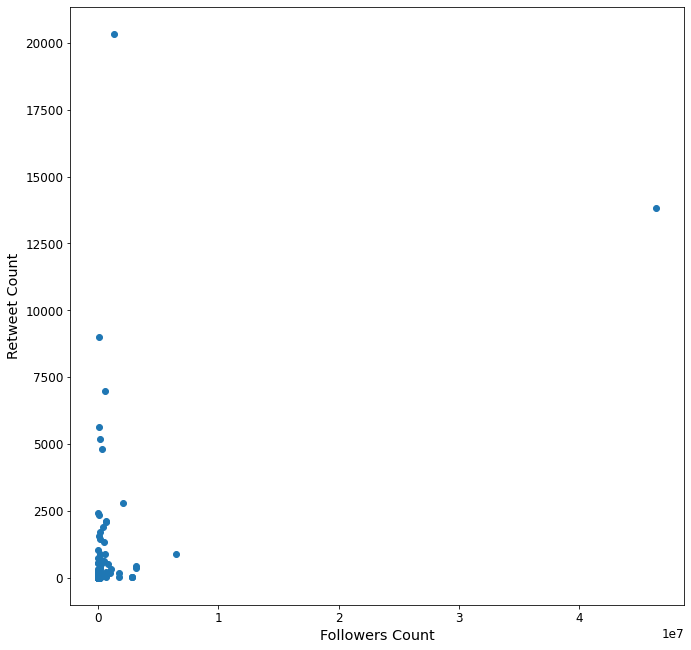

In [22]:
plt.scatter(df['followersCount'], df['retweetCount'])
plt.xlabel('Followers Count')
plt.ylabel('Retweet Count')
plt.show()

Should we apply a log transform to followers count and retweet count?

In [23]:
np.corrcoef(np.log(1+df['followersCount']), np.log(1+df['retweetCount']))

array([[1.        , 0.60546623],
       [0.60546623, 1.        ]])

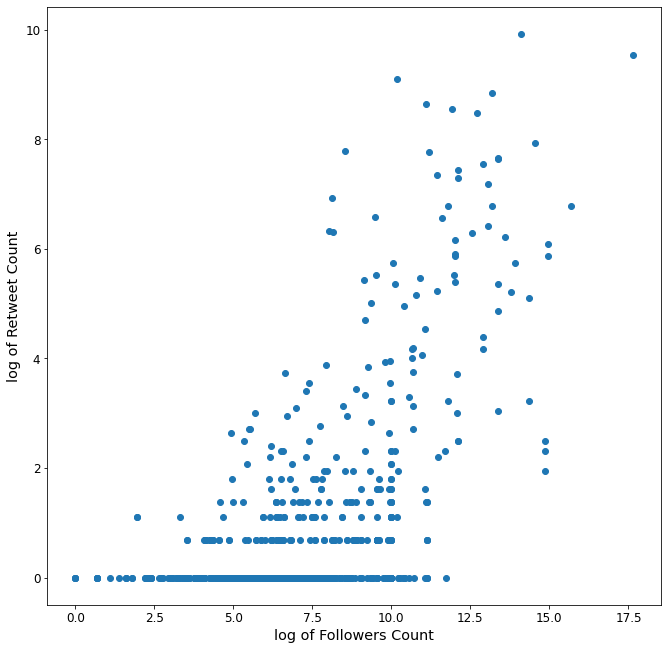

In [24]:
plt.scatter(np.log(1+df['followersCount']), np.log(1+df['retweetCount']))
plt.xlabel('log of Followers Count')
plt.ylabel('log of Retweet Count')
plt.show()

Look at the counts for each of retweet count levels. Are most tweets retweeted or not?

In [25]:
df['retweetCount'].value_counts()

0       387
1        83
2        33
3        29
4        12
       ... 
366       1
5617      1
608       1
27        1
41        1
Name: retweetCount, Length: 89, dtype: int64

Look at this same information in a histogram.

<AxesSubplot:>

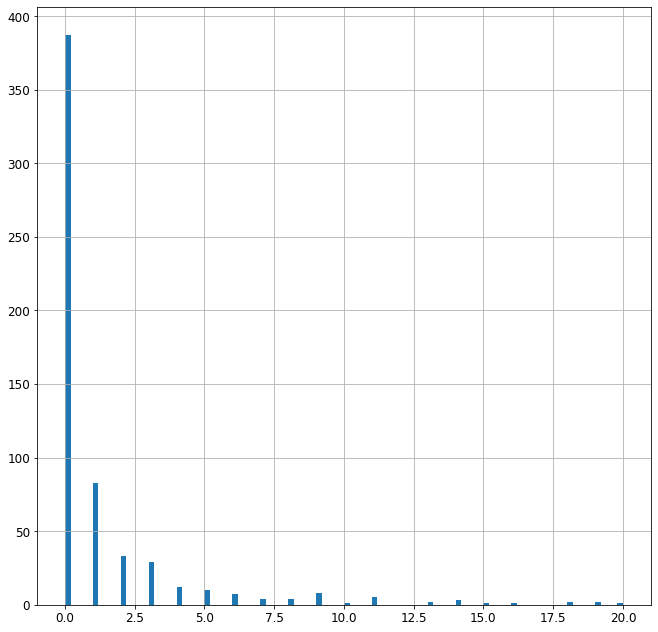

In [26]:
df['retweetCount'].hist(bins=100, range=(0,20))

Create two subsetted data frames -- one for tweets without any retweets and another for tweets that were retweeted.

In [27]:
df_no_retweet = df[df['retweetCount'] == 0]
df_some_retweet = df[df['retweetCount'] > 0]

# Create some wordclouds

Convert all the cleaned tweet texts into one long sentence. Then make a wordcloud.

In [28]:
one_long_string =  ' '.join(df['cleanTweetText'])

Replace variants of your key words.

In [29]:
one_long_string = one_long_string.replace('starwars', '')
one_long_string = one_long_string.replace('star', '')
one_long_string = one_long_string.replace('wars', '')
one_long_string = one_long_string.replace('war', '')

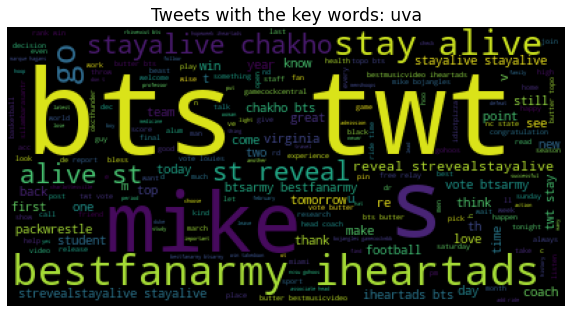

In [30]:
wordcloud = WordCloud().generate(one_long_string)
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud)
plt.axis("off")
plt.title('Tweets with the key words: ' + key_words)
plt.show()

Create two more wordclouds -- one for tweets without any retweets and another for tweets that were retweeted.

In [31]:
one_long_string_no_retweet =  ' '.join(df_no_retweet['cleanTweetText'])
one_long_string_some_retweet =  ' '.join(df_some_retweet['cleanTweetText'])

In [32]:
one_long_string_no_retweet = one_long_string_no_retweet.replace('starwars', '')
one_long_string_no_retweet = one_long_string_no_retweet.replace('star', '')
one_long_string_no_retweet = one_long_string_no_retweet.replace('wars', '')
one_long_string_no_retweet = one_long_string_no_retweet.replace('war', '')
one_long_string_some_retweet = one_long_string_some_retweet.replace('starwars', '')
one_long_string_some_retweet = one_long_string_some_retweet.replace('star', '')
one_long_string_some_retweet = one_long_string_some_retweet.replace('wars', '')
one_long_string_some_retweet = one_long_string_some_retweet.replace('war', '')

Are there any differences in the frequently used words in the non-retweeted and retweeted tweets?

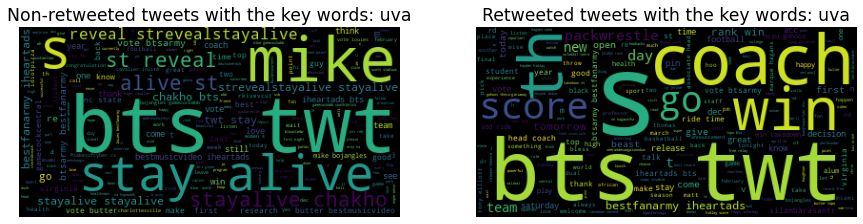

In [33]:
wordcloud_no_retweet = WordCloud(random_state=201).generate(one_long_string_no_retweet)
wordcloud_some_retweet = WordCloud(random_state=201).generate(one_long_string_some_retweet)

plt.figure(figsize=(15, 15))

plt.subplot(121)  # 121 means 1 row and 2 columns of plots and this is the first subplot.
plt.imshow(wordcloud_no_retweet)
plt.axis("off")
plt.title('Non-retweeted tweets with the key words: ' + key_words)

plt.subplot(122)  # 122 means 1 row and 2 columns of plots and this is the second subplot.
plt.imshow(wordcloud_some_retweet)
plt.axis("off")
plt.title('Retweeted tweets with the key words: ' + key_words)

plt.show()

# Create a bag of words

Create a corpus (a list of all your documents). Find all the one-word phrases (unigrams) and two-word phrases (bigrams). We could keep going higher, to find all n-word phrases (ngrams). Below we create a "bag of words" for the top 20 phrases (unigrams or bigrams in this case). A bag of words (or document-term matrix) is a data frame of phrase counts. Each row is a document (or tweet in this case). The columns correspond to a phrase in any of the documents. An entry in the data frame is a count of the times the phrase appears in the document.

In [34]:
corpus = list(df['cleanTweetText'])
corpus_vectorizer = CountVectorizer(ngram_range=(1, 2), max_features=30)
bag_of_words = corpus_vectorizer.fit_transform(corpus)
bag_of_words_df = pd.DataFrame(bag_of_words.toarray(), columns=corpus_vectorizer.get_feature_names())
bag_of_words_df

/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,alive,alive st,bestfanarmy,bestfanarmy iheartawards,bts,bts twt,btsarmy,butter,chakho,chakho bts,coach,get,go,iheartawards,mike,no,reveal,reveal strevealstayalive,st,st reveal,stay,stay alive,stayalive,stayalive chakho,stayalive stayalive,strevealstayalive,strevealstayalive stayalive,twt,vote,win
0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,4,2,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
668,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
669,0,0,0,0,1,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
670,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [35]:
pd.DataFrame(bag_of_words_df.mean(axis=0), index=bag_of_words_df.columns, columns=['Avg count (all tweets)'])

,Avg count (all tweets)
alive,0.049107
alive st,0.046131
bestfanarmy,0.062500
bestfanarmy iheartawards,0.053571
bts,0.215774
bts twt,0.171131
btsarmy,0.043155
butter,0.047619
chakho,0.047619
chakho bts,0.043155


Create two bag of words -- one for tweets with no retweets and another for tweets with some retweets. Are the frequently used words different?

In [36]:
corpus_no_retweet = list(df_no_retweet['cleanTweetText'])
corpus_no_retweet_vectorizer = CountVectorizer(ngram_range=(1, 2), max_features=20)
bag_of_words_no_retweet = corpus_no_retweet_vectorizer.fit_transform(corpus_no_retweet)
bag_of_words_no_retweet_df = pd.DataFrame(bag_of_words_no_retweet.toarray(), columns=corpus_no_retweet_vectorizer.get_feature_names())
bag_of_words_no_retweet_df

/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,alive,alive st,bestfanarmy,bts,bts twt,chakho,get,iheartawards,mike,reveal,st,st reveal,stay,stay alive,stayalive,stayalive chakho,strevealstayalive,strevealstayalive stayalive,twt,vote
0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,4,2,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
382,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
383,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
384,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
385,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1


In [37]:
corpus_some_retweet = list(df_some_retweet['cleanTweetText'])
corpus_some_retweet_vectorizer = CountVectorizer(ngram_range=(1, 2), max_features=20)
bag_of_words_some_retweet = corpus_some_retweet_vectorizer.fit_transform(corpus_some_retweet)
bag_of_words_some_retweet_df = pd.DataFrame(bag_of_words_some_retweet.toarray(), columns=corpus_some_retweet_vectorizer.get_feature_names())
bag_of_words_some_retweet_df

/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,bestfanarmy,bts,bts twt,coach,day,get,go,iheartawards,no,packwrestle,rank,release,saturday,score,takedown,th,time,twt,vote,win
0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
281,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
282,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
283,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [38]:
freq_words_no_retweet = pd.DataFrame(bag_of_words_no_retweet_df.mean(axis=0), 
                                     index=bag_of_words_no_retweet_df.columns, columns=['Avg count (no retweet)'])
freq_words_some_retweet = pd.DataFrame(bag_of_words_some_retweet_df.mean(axis=0), 
                                     index=bag_of_words_some_retweet_df.columns, columns=['Avg count (some retweet)'])

In [39]:
freq_words_no_retweet.join(freq_words_some_retweet, how='outer')

,Avg count (no retweet),Avg count (some retweet)
alive,0.080103,NaN
alive st,0.074935,NaN
bestfanarmy,0.074935,0.045614
bts,0.281654,0.126316
bts twt,0.224806,0.098246
chakho,0.077519,NaN
coach,NaN,0.094737
day,NaN,0.042105
get,0.085271,0.056140
go,NaN,0.045614


# Sentiment dictionary

We will use the hedonometer's sentiment dictionary measuring word happiness downloaded from http://hedonometer.org/index.html. The hedonometer project aims to measure aggregate happiness across time of users on Twitter by computing the sum of a happiness score of the words used by people on Twitter on that day. The website has a lot of very interesting information on the project.

In [40]:
happ_df = pd.read_csv('hedonometer_dict.tsv', sep="\t")

In [41]:
happ_df.head()

,word,happiness_rank,happiness_average,happiness_standard_deviation,twitter_rank,google_rank,nyt_rank,lyrics_rank
0,laughter,1,8.50,0.9313,3600,--,--,1728
1,happiness,2,8.44,0.9723,1853,2458,--,1230
2,love,3,8.42,1.1082,25,317,328,23
3,happy,4,8.30,0.9949,65,1372,1313,375
4,laughed,5,8.26,1.1572,3334,3542,--,2332


In [42]:
happ_df.tail()

,word,happiness_rank,happiness_average,happiness_standard_deviation,twitter_rank,google_rank,nyt_rank,lyrics_rank
10217,murder,10218,1.48,1.0150,2762,3110,1541,1059
10218,terrorism,10219,1.48,0.9089,--,--,3192,--
10219,rape,10220,1.44,0.7866,3133,--,4115,2977
10220,suicide,10221,1.30,0.8391,2124,4707,3319,2107
10221,terrorist,10222,1.30,0.9091,3576,--,3026,--


In [43]:
word_happs_df = happ_df[['word', 'happiness_average']]

In [44]:
word_happs_df.shape

(10222, 2)

# Feature engineering

Create a dummy variable for a tweet containing a specific handle, such as '@youtube'. Also, create a count of the number of handles in each tweet. In addition, calculate each tweet's happiness score (a sum of the words' happiness scores).

In [45]:
df_with_new_features = df.reset_index(drop=True)  # Reset the index of the data frame.

In [46]:
youtube_dummy = []
handle_count = []
happs_list = []
for i in range(0, len(df_with_new_features)):
    tweet = df_with_new_features.loc[i]['cleanTweetText']
    youtube_dummy.append(int('@youtube' in set(tweet.split())))   # Set a 1 if the handle "@youtube" occurs in the tweet.
    handle_count.append(tweet.count('@'))   # Count the number of handles (i.e. things that are preceded by '@').
    tweet_df = pd.DataFrame(pd.Series(tweet.split()), columns=['word'])  # Create a single column data frame of tweet's words.
    tweet_happs_df = pd.merge(tweet_df, word_happs_df, on='word')  # Assign happiness scores for all of the words in the tweet.
    happs_list.append(tweet_happs_df['happiness_average'].sum())  # Sum up the happiness scores.
df_with_new_features['contains_youtube'] = youtube_dummy
df_with_new_features['handle_count'] = handle_count
df_with_new_features['happ_score'] = happs_list

In [47]:
df_with_new_features.head()

,tweetText,tweetCreated,userTimeZone,userScreenName,followersCount,retweetCount,cleanTweetText,contains_youtube,handle_count,happ_score
0,@PJMlROCK uva\n\nI vote for #BTSARMY for the #...,2022-02-05 14:29:33+00:00,None,uarmyours,3235,0,@pjmlrock vote #btsarmy #bestfanarmy #ihearta...,0,1,5.80
1,RT @PackPride: No. 4 NC State obliterates UVA ...,2022-02-05 14:29:32+00:00,None,jerry41413871,68316,3,@packpride no nc state obliterate actual acc ...,0,1,26.64
2,@Mike_Uva How do we get the hat? I signed up,2022-02-05 14:27:20+00:00,None,jrdnmrtn,295,0,@mike get hat sign,0,1,17.28
3,@btsvotinbr @BTS_twt BUTTER NO TOPO + #BTS_But...,2022-02-05 14:26:33+00:00,None,bangtanipyou,122,0,@btsvotinbr @bts twt butter topo #bts butter #...,0,3,13.12
4,Every healthcare professional should read this...,2022-02-05 14:26:31+00:00,None,jessicaannlevy,680,0,every healthcare professional read thread pro...,0,1,46.64


# Fit a regression tree

In [48]:
ind_variables_selected = ['followersCount', 'contains_youtube', 'handle_count', 'happ_score']
X_train = df_with_new_features[ind_variables_selected]
y_train = df_with_new_features['retweetCount']
rt = DecisionTreeRegressor(min_samples_split=4, max_depth=4, random_state=201)
rt_model = rt.fit(X_train, y_train)
rt_pred = rt_model.predict(X_train)

Look at the variable importances.

In [49]:
pd.DataFrame({'Importance': rt_model.feature_importances_}, index=ind_variables_selected).sort_values(['Importance'], ascending=False)

,Importance
happ_score,0.515246
followersCount,0.484754
contains_youtube,0.000000
handle_count,0.000000


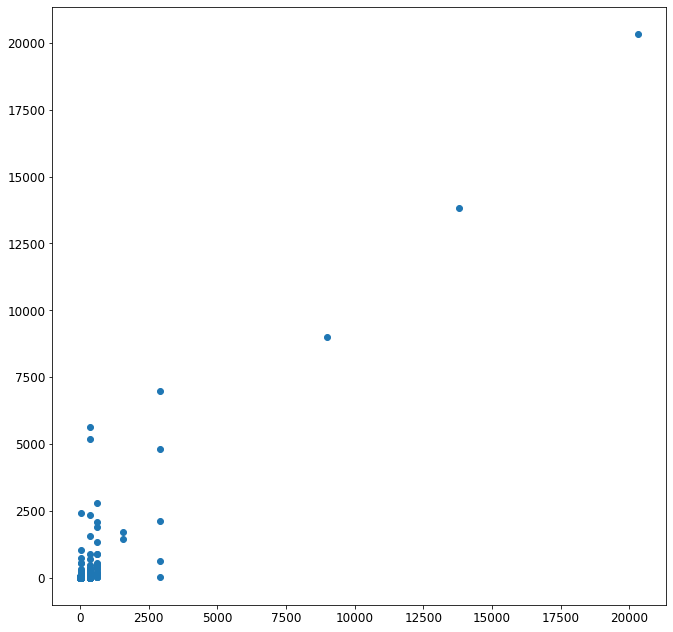

In [50]:
plt.scatter(rt_pred, y_train)

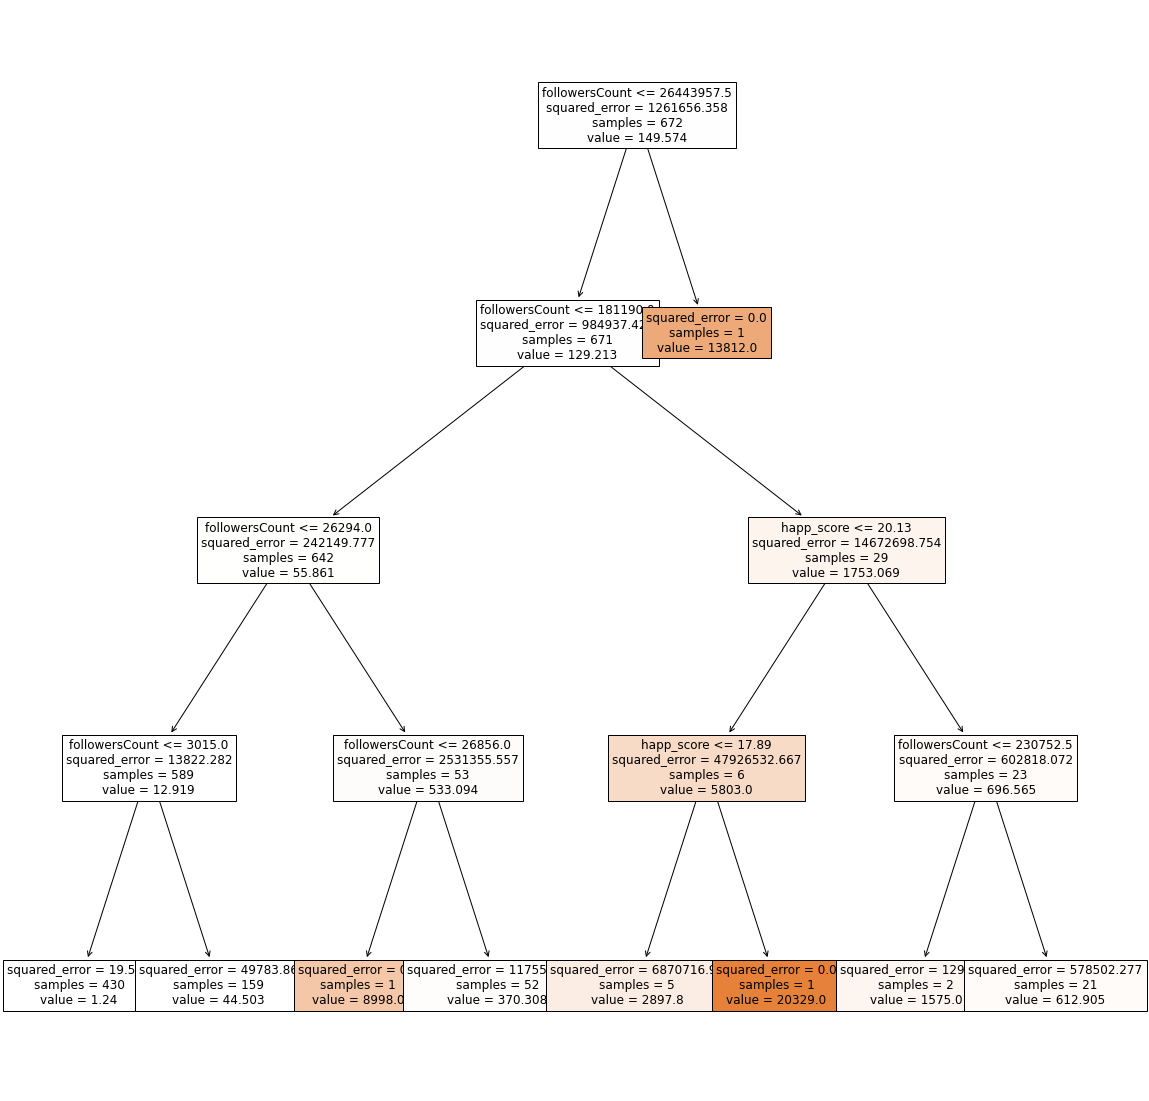

In [51]:
plt.figure(figsize=(20,20))
plot_tree(rt_model, feature_names=X_train.columns, filled=True, fontsize=12)
plt.show()